In [1]:
import glob
import numpy as np, pandas as pd, zipfile
import os
import random
import cv2
import gc


In [2]:
#import visualization packages
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import imageio

In [3]:
#import tensorflow libraries
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout ,Input,MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# to clear session
def reset_keras():
    tf.keras.backend.clear_session
    gc.collect

    

In [5]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 747272014334001502
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16120545280
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4263471419597621217
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


# Create dataframe for train and test

In [6]:
#create directory
base_dir = '/kaggle/input/dogs-vs-cats-redux-kernels-edition'
train_dir = '../data/train'
test_dir = '../data/test'

In [7]:
# Extract contents of 'train.zip' to '../data'
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
# Extract contents of 'test.zip' to '../data'    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

In [8]:
# Create a list of file paths for training images and test_images
train_image = glob.glob(os.path.join(train_dir,'*jpg'))
test_image = glob.glob(os.path.join(test_dir,'*jpg'))

In [10]:
all = np.zeros(25000)# Initializing an array of zeros with size 25000

train = []# Initializing an empty list to store training data
count = 0
for i in train_image:# Loop through the list of file paths for training images
    tempdata = [all[count],i] 
    train.append(tempdata) # Append the sublist to the 'train' list
    count+=1

In [11]:
#we will do the same for the test_images
test = []
count = 0
for i in test_image:
    test.append(i)
    count+=1

In [13]:
train = pd.DataFrame(train, columns=['label', 'id'])#create column name and append the list into the dataframe
test = pd.DataFrame(test, columns=['id'])

In [47]:
train
#id will have the file_path

,label,id
0,1,../data/train/dog.890.jpg
1,1,../data/train/dog.1178.jpg
2,1,../data/train/dog.7845.jpg
5,1,../data/train/dog.814.jpg
7,1,../data/train/dog.8575.jpg
...,...,...
24995,1,../data/train/dog.6505.jpg
24996,0,../data/train/cat.3805.jpg
24997,0,../data/train/cat.5513.jpg
24998,0,../data/train/cat.6808.jpg


In [14]:
train['id'].astype('string')#change the data type to string

for i, row in train.iterrows():
    if 'dog' in row['id']:#if dog appears in the 'id', the label will be 1
        train.at[i, 'label'] = '1'
    else:
        train.at[i, 'label'] = '0'

/tmp/ipykernel_47/1967292160.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train.at[i, 'label'] = '1'


# Split train images into train and validation

In [15]:
msk = np.random.rand(len(train)) < 0.8 # Create a boolean mask for random splitting (80% train, 20% validation)
val = train[~msk]
train = train[msk]


# Visualize image 

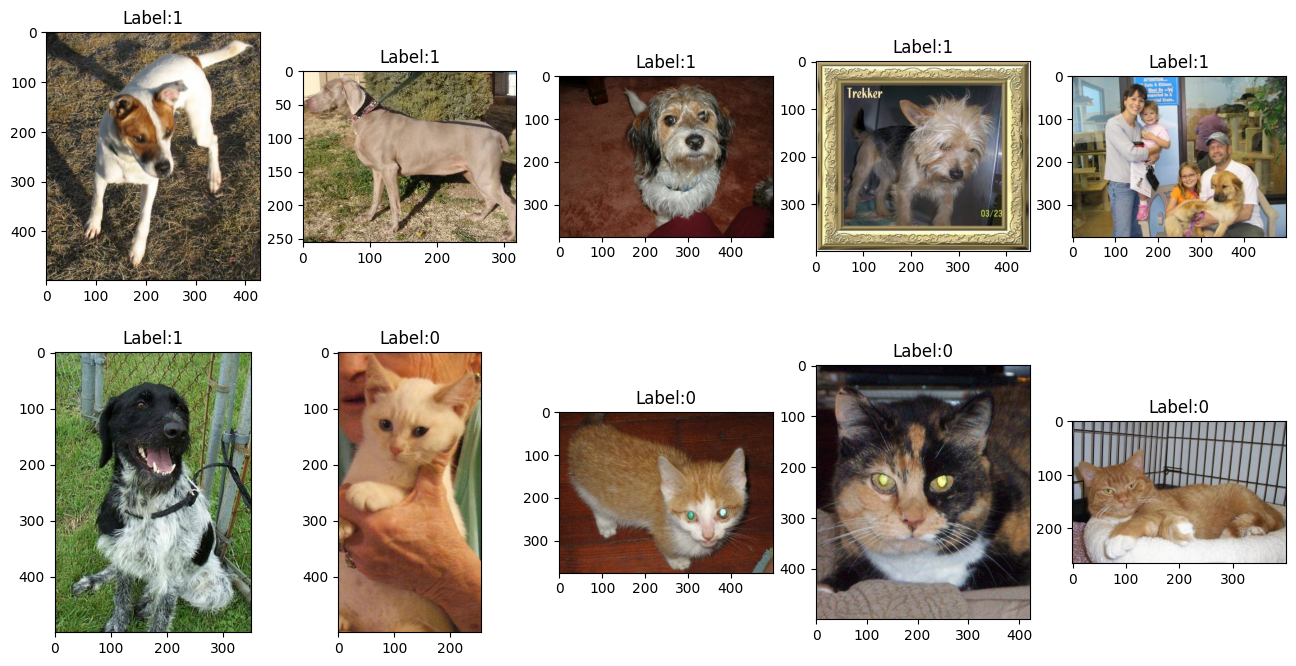

In [16]:
# 1 will be dog, 0 will be cat
fig = plt.figure(figsize = (16,8))
for i, (path,label) in enumerate(zip(train.iloc[:10,1],train.iloc[:10,0]),1):
    subplot = fig.add_subplot(2,5,i)
    subplot.set_title('Label:{}'.format(label))
    img = cv2.imread(path)[..., ::-1]# reverse the list
    #In OpenCV, images are typically represented in BGR (Blue, Green, Red) order, while some other libraries (like Matplotlib) use RGB (Red, Green, Blue) order
    subplot.imshow(img)

# Augmentation

In [18]:
size = 256 #image size
batch = 32 # number of batches

reset_keras()
random.seed(88)# Set random seed for reproducibility
with tf.device("/GPU:0"):


    aug = ImageDataGenerator(rescale=1./255, # Data augmentation for training
                            zoom_range=0.2,
                            rotation_range=20,
                            width_shift_range=0.2,
                            height_shift_range=0.2)

    train_generator = aug.flow_from_dataframe(dataframe = train,
                                              directory = None,
                                              x_col = 'id',#contains the file names or paths of the images.
                                              y_col = 'label',#labels corresponding to the images.
                                              class_mode = "categorical",#This will one-hot encode the labels.
                                              target_size = (size,size),
                                              shuffle = True,
                                              batch_size = batch,
                                              seed = 66)

    val_datagen = ImageDataGenerator(rescale=1./255)

    val_generator = val_datagen.flow_from_dataframe(dataframe = val,
                                                    x_col = 'id',
                                                    y_col = 'label',
                                                    class_mode = "categorical",
                                                    target_size = (size,size),
                                                    batch_size = batch,
                                                    seed = 99)

    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                    x_col = 'id',
                                                    directory = None,
                                                    color_mode = "rgb",#Set to "rgb" because the images are assumed to be in RGB format
                                                    target_size = (size,size),
                                                    batch_size = 1,
                                                    class_mode=None,
                                                    shuffle=False,#Set to False because we want to evaluate the model in in the order of the provided DataFrame.
                                                    seed = 100)

Found 19894 validated image filenames belonging to 2 classes.
Found 5106 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


# Model 1 (MobileNet)

In [19]:
#I used the model that professor explained in the video
model1 = tf.keras.applications.MobileNetV2(
    include_top=False, weights='imagenet', input_tensor=None, input_shape= (size,size,3),
    pooling=max, classes=2)

x = model1.output
x = Flatten()(x)
predictions1 = Dense(2, activation='softmax')(x)# 2 represent two classes

model1 = Model(inputs = model1.input, outputs=predictions1)

9406464/9406464 [==============================] - 1s 0us/step


In [20]:
with tf.device("/GPU:0"):
    model1 = model1
    SGD = tensorflow.keras.optimizers.SGD(lr=0.0001, nesterov=True)#this creates an instance of the SGD optimizer with a learning rate of 0.0001 and Nesterov momentum enabled
    model1.compile(loss = 'binary_crossentropy', optimizer = SGD, metrics=['binary_accuracy'])
    model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[0][0]']        

In [21]:
with tf.device("/GPU:0"):
    history1 = model1.fit(train_generator,
                          steps_per_epoch=train_generator.samples // batch,
                          epochs=20,
                          validation_data = val_generator,
                          validation_steps = val_generator.samples // batch)

Epoch 1/20
621/621 [==============================] - 323s 487ms/step - loss: 0.1529 - binary_accuracy: 0.9541 - val_loss: 0.1697 - val_binary_accuracy: 0.9589
Epoch 2/20
621/621 [==============================] - 304s 489ms/step - loss: 0.0554 - binary_accuracy: 0.9809 - val_loss: 0.0526 - val_binary_accuracy: 0.9837
Epoch 3/20
621/621 [==============================] - 296s 477ms/step - loss: 0.0371 - binary_accuracy: 0.9860 - val_loss: 0.0395 - val_binary_accuracy: 0.9896
Epoch 4/20
621/621 [==============================] - 291s 469ms/step - loss: 0.0344 - binary_accuracy: 0.9876 - val_loss: 0.0400 - val_binary_accuracy: 0.9855
Epoch 5/20
621/621 [==============================] - 291s 469ms/step - loss: 0.0258 - binary_accuracy: 0.9903 - val_loss: 0.0313 - val_binary_accuracy: 0.9880
Epoch 6/20
621/621 [==============================] - 292s 469ms/step - loss: 0.0231 - binary_accuracy: 0.9921 - val_loss: 0.0277 - val_binary_accuracy: 0.9914
Epoch 7/20
621/621 [====================

# Model 2 (vgg16)

In [22]:
reset_keras()
train_generator.reset()# It is advised reset the train generator if we want to train another model using the same train generator
val_generator.reset()

#I am using a vgg16 model for my second model
model2 = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', input_tensor=None, input_shape= (size,size,3),
    pooling=max)

x = model2.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)#If batchnormalization is not added the loss will be nan. 
predictions2 = Dense(2, activation='softmax')(x)

model2 = Model(inputs = model2.input, outputs=predictions2)

58889256/58889256 [==============================] - 3s 0us/step


In [23]:
reset_keras()
model2 = model2
SGD = tensorflow.keras.optimizers.SGD(lr=0.00001, nesterov=True)
model2.compile(loss = 'binary_crossentropy', optimizer = SGD, metrics=['binary_accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [24]:
reset_keras()
history2 = model2.fit(train_generator,
                    epochs=20,
                    validation_data = val_generator)

Epoch 1/20
622/622 [==============================] - 310s 484ms/step - loss: 0.2543 - binary_accuracy: 0.8909 - val_loss: 14.4031 - val_binary_accuracy: 0.9444
Epoch 2/20
622/622 [==============================] - 299s 481ms/step - loss: 0.1096 - binary_accuracy: 0.9585 - val_loss: 24.3649 - val_binary_accuracy: 0.9832
Epoch 3/20
622/622 [==============================] - 294s 472ms/step - loss: 0.0825 - binary_accuracy: 0.9695 - val_loss: 43.9188 - val_binary_accuracy: 0.9777
Epoch 4/20
622/622 [==============================] - 295s 473ms/step - loss: 0.0693 - binary_accuracy: 0.9742 - val_loss: 34.7449 - val_binary_accuracy: 0.9847
Epoch 5/20
622/622 [==============================] - 294s 473ms/step - loss: 0.0623 - binary_accuracy: 0.9781 - val_loss: 38.9011 - val_binary_accuracy: 0.9832
Epoch 6/20
622/622 [==============================] - 296s 476ms/step - loss: 0.0529 - binary_accuracy: 0.9796 - val_loss: 52.9513 - val_binary_accuracy: 0.9788
Epoch 7/20
622/622 [==============

In [48]:
def plot_accuracy_and_loss(train_model, model_name):
    hist = train_model.history
    acc = hist['binary_accuracy']
    val_acc = hist['val_binary_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(16,4))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy', marker='D', mec='b', ms='3')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy', marker='o', mec='yellow', ms='3')
    ax[0].set_title('{} Training and validation accuracy'.format(model_name))
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss', marker='D', mec='b', ms='3')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss', marker='o', mec='yellow', ms='3')
    ax[1].set_title('{} Training and validation accuracy'.format(model_name))
    ax[1].legend()
    plt.show()
    


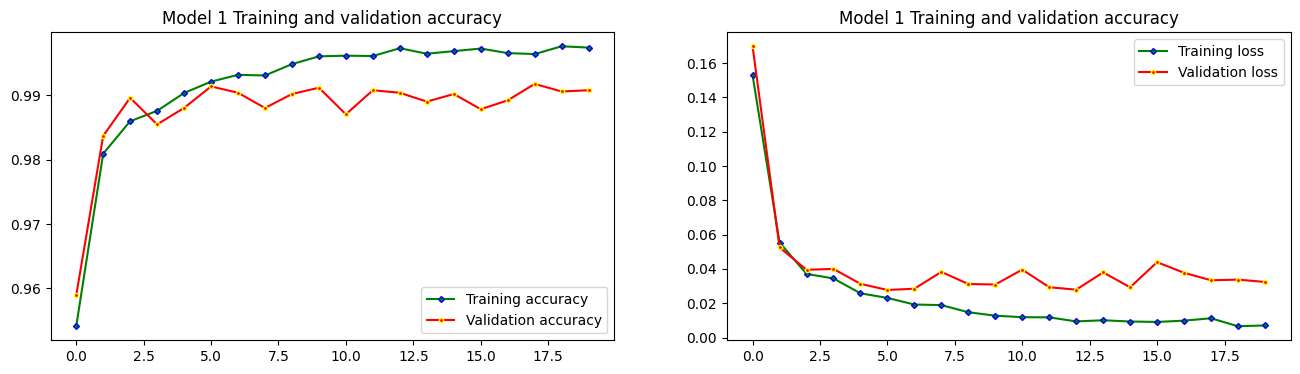

In [52]:
history1_plot = plot_accuracy_and_loss(history1, 'Model 1')

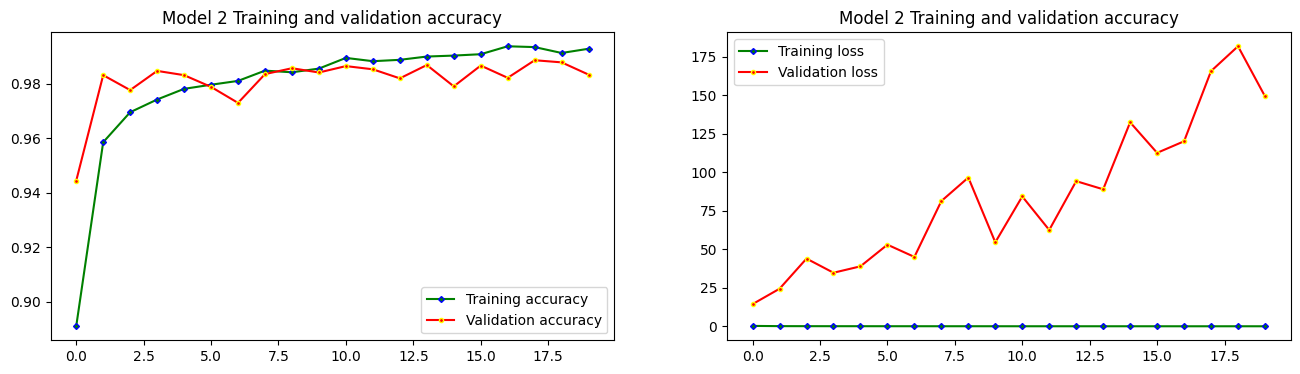

In [51]:
history2_plot = plot_accuracy_and_loss(history2, 'Model 2')

# Prediction

In [45]:
#model1 prediction
reset_keras()
test_generator.reset()
pred1 = model1.predict(test_generator, steps = 125000,verbose=1)

125000/125000 [==============================] - 71s 564us/step


In [46]:
#model2 prediction
reset_keras()
test_generator.reset()
pred2 = model2.predict(test_generator, steps = 125000,verbose=1)

125000/125000 [==============================] - 69s 549us/step


In [32]:
pred1 = np.round(pred1[:,1],4) #if use argmax, the score of the competition will lower
pred2 = np.round(pred2[:,1],4)


In [34]:
#extract image id from the image_path
id = []
for test_path in test['id']:
    _id = int(test_path.split('/')[-1].split('.')[0])
    id.append(_id)
    
 

In [35]:
result1 = pd.DataFrame({'id' : id, 'label':pred1})
result2 = pd.DataFrame({'id' : id, 'label':pred2})

In [37]:
result1.to_csv('submission1.csv',index=False)
result2.to_csv('submission2.csv',index=False)

# Visualize Result
Now we will be visualizing the result to see does our images match their labels.

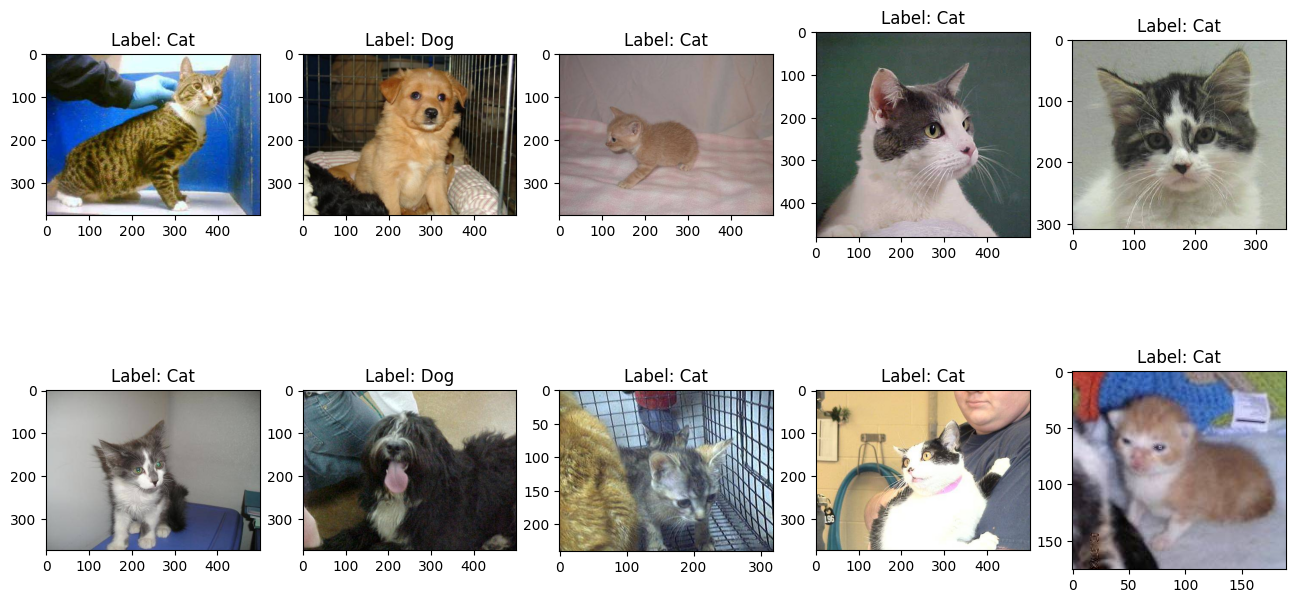

In [53]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test.iloc[:10,0], result1.iloc[:10,1]), 1):
    subplot = fig.add_subplot(2, 5, i)
    if score  > 0.5:
          str_label='Dog'
    else:
        str_label='Cat'
    subplot.set_title("Label: {}".format(str_label))
    img = cv2.imread(path)[...,::-1]
    subplot.imshow(img)

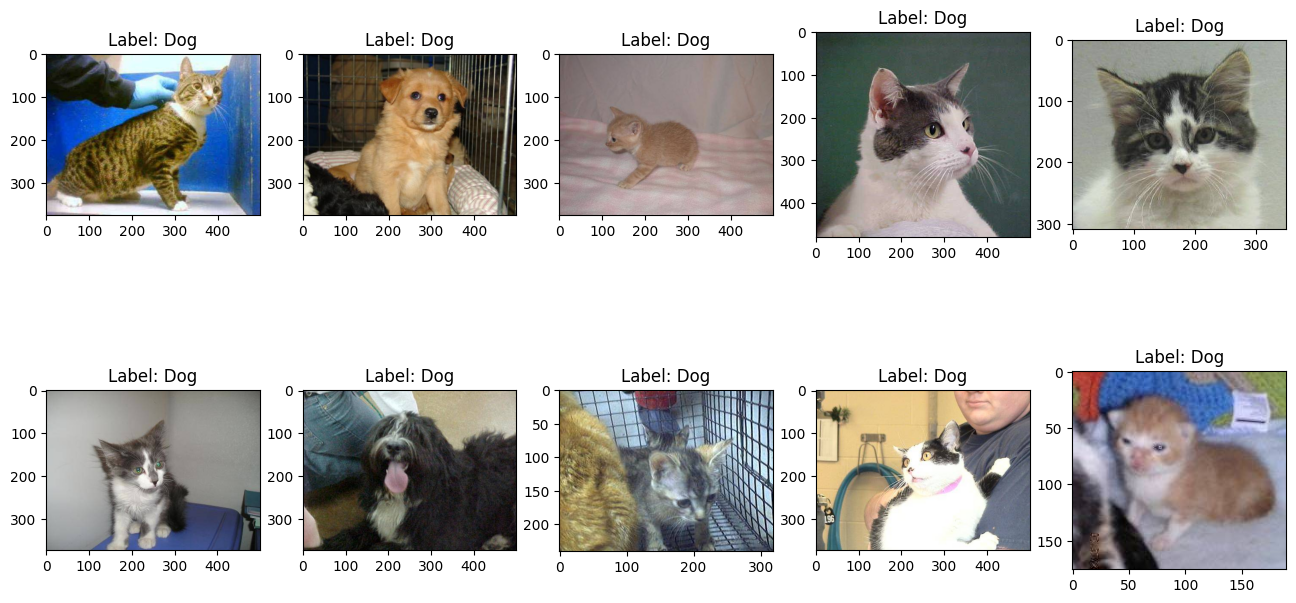

In [41]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test.iloc[:10,0], result2.iloc[:10,1]), 1):
    subplot = fig.add_subplot(2, 5, i)
    if score  > 0.5:
          str_label='Dog'
    else:
        str_label='Cat'
    subplot.set_title("Label: {}".format(str_label))
    img = cv2.imread(path)[...,::-1]
    subplot.imshow(img)